In [17]:
import torch
import gc

# Run garbage collection
gc.collect()

# Empty MPS cache
if torch.backends.mps.is_available():
    torch.mps.empty_cache()


In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd

# Load model and tokenizer
model_name = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

In [20]:
import pandas as pd

# Load the file with tab separator and skip bad lines
df = pd.read_csv("FLAT_CMPL.txt", sep="\t", header=None, engine="python", on_bad_lines="skip")

# Rename relevant columns
df = df[[11, 19]]
df.columns = ["COMPDESC", "CDESCR"]



In [22]:
df.head()

,COMPDESC,CDESCR
0,ENGINE AND ENGINE COOLING:COOLING SYSTEM:RADIA...,RADIATOR FAILED @ HIGHWAY SPEED OBSTRUCTING DR...
1,"FUEL SYSTEM, GASOLINE:DELIVERY","FUEL LEAKED FROM FUEL TANK AREA, EMITTING STRO..."
2,POWER TRAIN:AUTOMATIC TRANSMISSION,SHIFTED INTO REVERSE VEHICLE JERKED VIOLENTLY....
3,"FUEL SYSTEM, GASOLINE:STORAGE:TANK ASSEMBLY",FUEL TANK ; LEAKS BECAUSE OF RUST GAS LEAK BY ...
4,SEATS,"DRIVER SIDE SEAT FRAME BROKE IN TWO, CAUSING S..."


In [25]:
import pandas as pd

# Your target categories
target_categories = [
    'ELECTRICAL SYSTEM',
    'AIR BAGS',
    'WHEELS',
    'ENGINE AND ENGINE COOLING',
    'STRUCTURE'
]

# Filter df to keep only rows where COMPDESC is in target_categories
filtered_df = df[df['COMPDESC'].isin(target_categories)]

# Display or use the filtered dataframe
print(filtered_df)


                  COMPDESC                                             CDESCR
22                AIR BAGS  UPON IMPACT, DURING FRONTAL CRASH AT APPROX. 1...
65                  WHEELS  RIGHT FRONT WHEEL LOCKED UP VEHICLE WENT INTO ...
154               AIR BAGS  DRIVER AND PASSENGER AIRBAG DID NOT DEPLOY IN ...
228                 WHEELS  WHEEL CRACKED ON RIGHT FRONT WHEEL WHILE DRIVI...
310                 WHEELS                     WHEELS SKID WHEN BRAKING.  *AK
...                    ...                                                ...
1681978             WHEELS  I TOOK MY TRUCK INTO THE DEALERSHIP FOR SERVIC...
1681979           AIR BAGS  I KEEP RECEIVING SAFETY RECALL LETTERS ABOUT T...
1681984  ELECTRICAL SYSTEM  SO FROM THE START I BOUGHT THE CAR $5000 CASH ...
1681992  ELECTRICAL SYSTEM  THE CAR CAUGHT ON FIRE, STARTING IN THE ROOF. ...
1681998           AIR BAGS  I BOUGHT THE CAR IN APRIL.2020, THE AIR BAG WA...

[293318 rows x 2 columns]


In [27]:
filtered_df.head()

,COMPDESC,CDESCR
22,AIR BAGS,"UPON IMPACT, DURING FRONTAL CRASH AT APPROX. 1..."
65,WHEELS,RIGHT FRONT WHEEL LOCKED UP VEHICLE WENT INTO ...
154,AIR BAGS,DRIVER AND PASSENGER AIRBAG DID NOT DEPLOY IN ...
228,WHEELS,WHEEL CRACKED ON RIGHT FRONT WHEEL WHILE DRIVI...
310,WHEELS,WHEELS SKID WHEN BRAKING. *AK


In [29]:
# Define the mapping for your categories to labels
category_to_label = {
    'ELECTRICAL SYSTEM': 1,
    'AIR BAGS': 2,
    'WHEELS': 3,
    'ENGINE AND ENGINE COOLING': 4,
    'STRUCTURE': 5
}

# Apply the mapping to filtered_df to create a new column 'Category_Label'
filtered_df['Category_Label'] = filtered_df['COMPDESC'].map(category_to_label)



/var/folders/hx/q1s4c6ws0dn84_dnnjvs7skc0000gp/T/ipykernel_64212/83180464.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Category_Label'] = filtered_df['COMPDESC'].map(category_to_label)


In [31]:
filtered_df.head()

,COMPDESC,CDESCR,Category_Label
22,AIR BAGS,"UPON IMPACT, DURING FRONTAL CRASH AT APPROX. 1...",2
65,WHEELS,RIGHT FRONT WHEEL LOCKED UP VEHICLE WENT INTO ...,3
154,AIR BAGS,DRIVER AND PASSENGER AIRBAG DID NOT DEPLOY IN ...,2
228,WHEELS,WHEEL CRACKED ON RIGHT FRONT WHEEL WHILE DRIVI...,3
310,WHEELS,WHEELS SKID WHEN BRAKING. *AK,3


In [169]:
filtered_df.shape

(293318, 3)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/var/folders/hx/q1s4c6ws0dn84_dnnjvs7skc0000gp/T/ipykernel_64212/2471000386.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, x='Category_Label', palette='viridis')


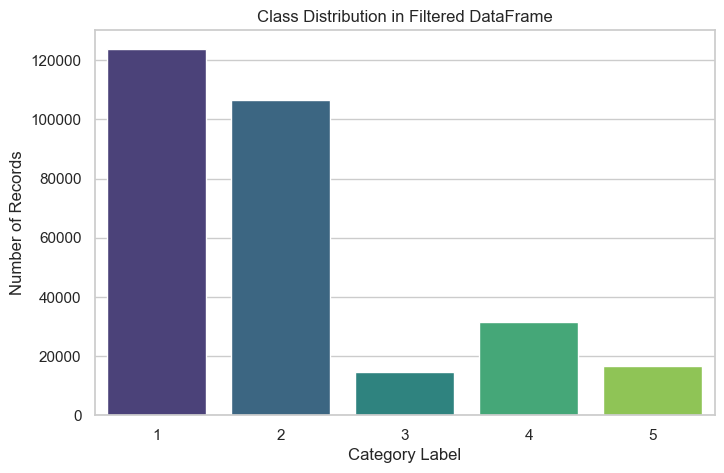

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot the count of each category label
plt.figure(figsize=(8, 5))
sns.countplot(data=filtered_df, x='Category_Label', palette='viridis')

# Customize plot labels and title
plt.xlabel('Category Label')
plt.ylabel('Number of Records')
plt.title('Class Distribution in Filtered DataFrame')
plt.xticks(ticks=[0,1,2,3,4], labels=['1','2','3','4','5'])  # optional if you want numeric labels
plt.show()


In [141]:
def classify_complaint(text):
    prompt = f'''Human: You are an expert field quality engineer who have to classify 
    descriptions of car failures into specific categories based on detailed descriptions of symptoms and failures. 
    Please analyze the <complaint> described below and classify it by returning only the appropriate <category> label.
    Complaint : "{text}" You must choose only from the following categories: 
    − 1: ’ELECTRICAL SYSTEM: Problems related to wiring, battery, power windows, fuses.’
    − 2: ’AIR BAGS: Complaints involving non-deployment, or unexpected deployment of air bags.’
    − 3: ’WHEELS: Complaints about wheel cracks, front wheel, RIGHT FRONT WHEEL LOCKED UP, tires, rims, cracking, balancing, or alignment problems.’
    − 4: ’ENGINE AND ENGINE COOLING: Problems such as overheating, temperature guage failed,INACCURATE TEMPERATURE READINGS, stalling, rough idling, or check engine lights.’ 
    − 5: ’STRUCTURE: Complaints about the body, doors, windows, roof, or frame.’ 
    Choose the most relevant category based on the complaint described. Return only the category label. Nothing else is required.
    Assistant: '''
    
    # Encode the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate output tokens
    outputs = model.generate(**inputs, max_new_tokens=20, do_sample=False)

    # Decode generated tokens, skip the prompt part
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True).strip()

    # Return the predicted category label
    return response



In [147]:
# Example usage:
example_text = "HOLE IN ALUMINUM WHEEL CAST, CAUSING LOSS OF AIR IN TIRES."
predicted_category = classify_complaint(example_text)
print(f"Predicted category: {predicted_category}")

Predicted category: 3


In [145]:
sample_df['CDESCR'][6172]

'HOLE IN ALUMINUM WHEEL CAST, CAUSING LOSS OF AIR IN TIRES.   *AK'

In [149]:

sample_df = filtered_df.head(10000).copy()

# Run prediction and keep ground truth
sample_df['predicted_category'] = sample_df['CDESCR'].apply(classify_complaint)

# Show sample with complaint, ground truth, and prediction
print(sample_df[['CDESCR', 'Category_Label', 'predicted_category']].head(100))

                                                 CDESCR  Category_Label  \
22    UPON IMPACT, DURING FRONTAL CRASH AT APPROX. 1...               2   
65    RIGHT FRONT WHEEL LOCKED UP VEHICLE WENT INTO ...               3   
154   DRIVER AND PASSENGER AIRBAG DID NOT DEPLOY IN ...               2   
228   WHEEL CRACKED ON RIGHT FRONT WHEEL WHILE DRIVI...               3   
310                      WHEELS SKID WHEN BRAKING.  *AK               3   
...                                                 ...             ...   
5961  TEMERATURE GAUGE FAILED, SHOWED INACCURATE TEM...               4   
6020  NO DEPLOYMENT OF DRIVER'S AIRBAG DURING ACCIDE...               2   
6074  FALSE DEPLOYMENT OF DRIVER'S/PASSENGER'S AIRBA...               2   
6155                               ELECTRICAL PROBLEMS.               1   
6172  HOLE IN ALUMINUM WHEEL CAST, CAUSING LOSS OF A...               3   

     predicted_category  
22                    2  
65                    1  
154                  

In [ ]:
sample_df.head()

,COMPDESC,CDESCR,Category_Label,predicted_category
22,AIR BAGS,"UPON IMPACT, DURING FRONTAL CRASH AT APPROX. 1...",2,2
65,WHEELS,RIGHT FRONT WHEEL LOCKED UP VEHICLE WENT INTO ...,3,1
154,AIR BAGS,DRIVER AND PASSENGER AIRBAG DID NOT DEPLOY IN ...,2,2
228,WHEELS,WHEEL CRACKED ON RIGHT FRONT WHEEL WHILE DRIVI...,3,3
310,WHEELS,WHEELS SKID WHEN BRAKING. *AK,3,3


In [ ]:
from sklearn.metrics import classification_report

# Ensure all labels are strings and strip whitespace
sample_df['Category_Label'] = sample_df['Category_Label'].astype(str).str.strip()
sample_df['predicted_category'] = sample_df['predicted_category'].astype(str).str.strip()

# Generate classification report
report = classification_report(
    sample_df['Category_Label'],
    sample_df['predicted_category'],
    labels=[
        '1',
        '2',
        '3',
        '4',
        '5'
    ],
    zero_division=0
)

print(report)


              precision    recall  f1-score   support

           1       0.48      0.51      0.49      2150
           2       0.82      0.69      0.75      4836
           3       0.86      0.45      0.59      1259
           4       0.26      0.32      0.28       698
           5       0.15      0.07      0.09      1057

   micro avg       0.63      0.53      0.58     10000
   macro avg       0.51      0.41      0.44     10000
weighted avg       0.64      0.53      0.57     10000



In [153]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load small Flan-T5 model and tokenizer
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)




Predicted category: ELECTRICAL SYSTEM


In [157]:
def classify_complaint(text):
    prompt = f'''Human: You are an expert field quality engineer who have to classify 
    descriptions of car failures into specific categories based on detailed descriptions of symptoms and failures. 
    Please analyze the <complaint> described below and classify it by returning only the appropriate <category> label.
    Complaint : "{text}" You must choose only from the following categories: 
    − 1: ’ELECTRICAL SYSTEM: Problems related to wiring, battery, power windows, fuses.’
    − 2: ’AIR BAGS: Complaints involving non-deployment, or unexpected deployment of air bags.’
    − 3: ’WHEELS: Complaints about wheel cracks, front wheel, RIGHT FRONT WHEEL LOCKED UP, tires, rims, cracking, balancing, or alignment problems.’
    − 4: ’ENGINE AND ENGINE COOLING: Problems such as overheating, temperature guage failed,INACCURATE TEMPERATURE READINGS, stalling, rough idling, or check engine lights.’ 
    − 5: ’STRUCTURE: Complaints about the body, doors, windows, roof, or frame.’ 
    Choose the most relevant category based on the complaint described. Return only the category label. Nothing else is required.
    Assistant: '''
    
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=20)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction.strip()

# Example usage
example_text = "HOLE IN ALUMINUM WHEEL CAST, CAUSING LOSS OF AIR IN TIRES. "
predicted_category = classify_complaint(example_text)
print(f"Predicted category: {predicted_category}")

Predicted category: 4


In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch
from sklearn.metrics import classification_report

# Load your filtered dataframe
# Make sure 'CDESCR' is text and 'Category_Label' is int (0–4 or 1–5)
df = filtered_df.copy()
df = df.dropna(subset=["CDESCR"])
df["CDESCR"] = df["CDESCR"].astype(str)
df["Category_Label"] = df["Category_Label"].astype(int) - 1  # convert to 0-based labels

# Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Category_Label"])

# Convert to Hugging Face dataset
train_dataset = Dataset.from_pandas(train_df[["CDESCR", "Category_Label"]])
test_dataset = Dataset.from_pandas(test_df[["CDESCR", "Category_Label"]])

# Load tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize(batch):
    return tokenizer(batch["CDESCR"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Rename label column
train_dataset = train_dataset.rename_column("Category_Label", "labels")
test_dataset = test_dataset.rename_column("Category_Label", "labels")

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load model
num_labels = df["Category_Label"].nunique()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate
preds = trainer.predict(test_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)
true_labels = preds.label_ids

# Classification report
print(classification_report(true_labels, pred_labels, target_names=[
    "ELECTRICAL SYSTEM", "AIR BAGS", "WHEELS", "ENGINE AND ENGINE COOLING", "STRUCTURE"
]))


Map:   0%|          | 0/234643 [00:00<?, ? examples/s]

Map:   0%|          | 0/58661 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.337500,0.351963,0.874056,0.874604,0.876714,0.874056
2,0.316200,0.333750,0.880721,0.879799,0.880401,0.880721
3,0.286800,0.350189,0.878539,0.878422,0.878849,0.878539
4,0.230200,0.412975,0.874789,0.874500,0.874444,0.874789


                           precision    recall  f1-score   support

        ELECTRICAL SYSTEM       0.87      0.91      0.89     24799
                 AIR BAGS       0.93      0.93      0.93     21305
                   WHEELS       0.89      0.78      0.83      2940
ENGINE AND ENGINE COOLING       0.80      0.70      0.75      6269
                STRUCTURE       0.76      0.81      0.78      3348

                 accuracy                           0.88     58661
                macro avg       0.85      0.82      0.84     58661
             weighted avg       0.88      0.88      0.88     58661



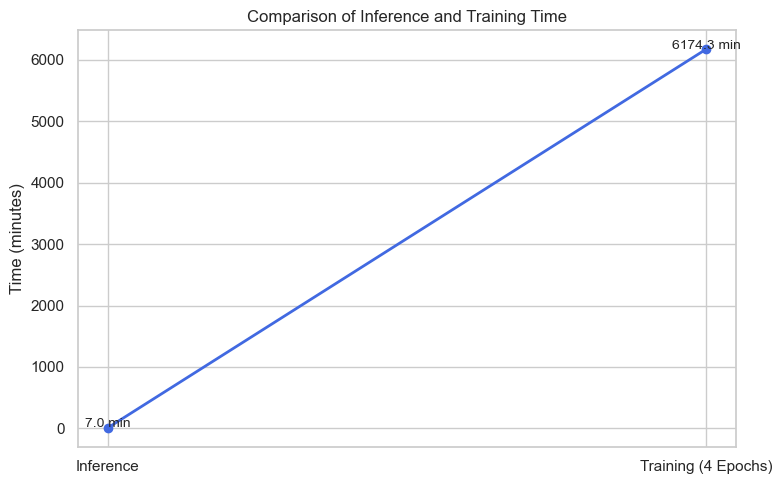

In [167]:
import matplotlib.pyplot as plt

# Convert time to minutes
inference_time_min = 7

# Training time: 102 hours, 54 minutes, 18 seconds = total minutes
training_hours, training_minutes, training_seconds = 102, 54, 18
total_training_minutes = training_hours * 60 + training_minutes + training_seconds / 60

# Line chart
phases = ['Inference', 'Training (4 Epochs)']
times = [inference_time_min, total_training_minutes]

plt.figure(figsize=(8, 5))
plt.plot(phases, times, marker='o', linestyle='-', color='royalblue', linewidth=2)

plt.title('Comparison of Inference and Training Time')
plt.ylabel('Time (minutes)')
plt.grid(True)
plt.tight_layout()

# Annotate values
for i, val in enumerate(times):
    plt.text(i, val + 10, f"{val:.1f} min", ha='center', fontsize=10)

plt.show()


In [173]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Load and preprocess your dataframe
df = filtered_df.copy()
df = df.dropna(subset=["CDESCR"])
df["CDESCR"] = df["CDESCR"].astype(str)
df["Category_Label"] = df["Category_Label"].astype(int) - 1  # convert to 0-based labels

# Limit dataset to 2000 examples, stratified by label to maintain balance
df_sampled, _ = train_test_split(df, train_size=2000, stratify=df["Category_Label"], random_state=42)

# Split into train/test
train_df, test_df = train_test_split(df_sampled, test_size=0.2, stratify=df_sampled["Category_Label"], random_state=42)

# Convert to Hugging Face dataset
train_dataset = Dataset.from_pandas(train_df[["CDESCR", "Category_Label"]])
test_dataset = Dataset.from_pandas(test_df[["CDESCR", "Category_Label"]])

# Load tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize(batch):
    return tokenizer(batch["CDESCR"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Rename label column
train_dataset = train_dataset.rename_column("Category_Label", "labels")
test_dataset = test_dataset.rename_column("Category_Label", "labels")

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load model
num_labels = df_sampled["Category_Label"].nunique()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_classification_small",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_small",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate
preds = trainer.predict(test_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)
true_labels = preds.label_ids

# Classification report
print(classification_report(true_labels, pred_labels, target_names=[
    "ELECTRICAL SYSTEM", "AIR BAGS", "WHEELS", "ENGINE AND ENGINE COOLING", "STRUCTURE"
]))


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.589590,0.777500,0.782658,0.817741,0.777500
2,No log,0.481745,0.840000,0.833735,0.834522,0.840000
3,No log,0.470466,0.860000,0.856746,0.860413,0.860000
4,No log,0.473030,0.870000,0.867645,0.868660,0.870000


                           precision    recall  f1-score   support

        ELECTRICAL SYSTEM       0.82      0.92      0.87       169
                 AIR BAGS       0.95      0.92      0.93       145
                   WHEELS       0.83      0.75      0.79        20
ENGINE AND ENGINE COOLING       0.73      0.56      0.63        43
                STRUCTURE       0.89      0.70      0.78        23

                 accuracy                           0.86       400
                macro avg       0.84      0.77      0.80       400
             weighted avg       0.86      0.86      0.86       400



In [193]:
from transformers import MarianMTModel, MarianTokenizer
import torch

def get_translation_pipeline(src_lang, tgt_lang):
    model_name = f'Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}'
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    return tokenizer, model

def translate(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        translated = model.generate(**inputs)
    return [tokenizer.decode(t, skip_special_tokens=True) for t in translated]

# Load translation models
en_to_fr_tok, en_to_fr_mod = get_translation_pipeline("en", "fr")
fr_to_en_tok, fr_to_en_mod = get_translation_pipeline("fr", "en")

# Back-translation function
def back_translate_marian(text):
    try:
        # Step 1: English → French
        fr = translate([text], en_to_fr_tok, en_to_fr_mod)[0]
        # Step 2: French → English
        en = translate([fr], fr_to_en_tok, fr_to_en_mod)[0]
        return en
    except Exception as e:
        print(f"Translation error: {e}")
        return text


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [195]:
test_sample = test_df.sample(n=200, random_state=42).copy()
test_sample["CDESCR_noisy"] = test_sample["CDESCR"].apply(back_translate_marian)


In [197]:
from datasets import Dataset

noisy_dataset = Dataset.from_pandas(test_sample[["CDESCR_noisy", "Category_Label"]])
noisy_dataset = noisy_dataset.rename_column("CDESCR_noisy", "CDESCR")
noisy_dataset = noisy_dataset.map(tokenize, batched=True)
noisy_dataset = noisy_dataset.rename_column("Category_Label", "labels")
noisy_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Evaluate on noisy samples
noisy_preds = trainer.predict(noisy_dataset)
noisy_labels = np.argmax(noisy_preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(noisy_preds.label_ids, noisy_labels))


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       0.71      0.91      0.80        79
           1       0.91      0.84      0.87        74
           2       1.00      0.31      0.47        13
           3       0.75      0.50      0.60        24
           4       0.50      0.50      0.50        10

    accuracy                           0.78       200
   macro avg       0.77      0.61      0.65       200
weighted avg       0.80      0.78      0.76       200

